# Tensorboard Demo for Image Embeddings

Generate image embeddings that can be used with Tensorboar Projector capability to visualize labels

In [1]:

#%%
import tensorflow as tf

from tensorflow.python.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.python.keras.models import Model
import numpy as np

# fix dimension ordering issue
from tensorflow.python.keras import backend as K
print(K.image_data_format())

from tensorflow.contrib.tensorboard.plugins import projector

import matplotlib.pyplot as plt
import os.path
import os
import numpy as np

from skimage import io as imgio, transform, util as imgutil

import warnings
warnings.filterwarnings('ignore')

channels_last


In [2]:
#%%
# location for tensorboard data structures
LOG_DIR = './cat_dog_embeddings_logs'

# location of image files
IMG_DIR = '/Users/jim/Desktop/Deeplearning/transfer_learning/cats_dogs/data/train'

# number of cat images and dog images to select
IMGS_TO_SELECT = 1250

SPRITE_IMG_SIZE = 64
SPRITE_COLUMNS = 50

In [3]:
#%%
# =============================================================================
# Retrieve pre-trained image CNN to generate embeddings
# =============================================================================

# retrireve ResNet50 CNN
base_model = ResNet50(weights='imagenet')
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [4]:
#%%
# create new model by excluding final classification layer
embed_model = Model(inputs=base_model.input,
                       outputs=base_model.get_layer('flatten_1').output)
embed_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [5]:
#%%
EMBED_MODEL_SHAPE = embed_model.layers[0].input_shape[1:3]

def generate_embedding(img):
    img = center_crop_img(img)
    img = transform.resize(img,EMBED_MODEL_SHAPE)\
        .reshape(-1,EMBED_MODEL_SHAPE[0],EMBED_MODEL_SHAPE[1],3)
    img = preprocess_input(img)
    embedding = embed_model.predict(img)
    return embedding
    

## Generate Metadata for Embeddings

### Generate image sprites

In [6]:
#%%
# =============================================================================
# select image files to create embedding
# =============================================================================
cat_imgs = np.array(os.listdir(os.path.join(IMG_DIR,'cats')))
dog_imgs = np.array(os.listdir(os.path.join(IMG_DIR,'dogs')))

# set seed
np.random.seed(13)

cat_imgs = cat_imgs[np.random.choice(cat_imgs.shape[0],IMGS_TO_SELECT,replace=False)]
dog_imgs = dog_imgs[np.random.choice(dog_imgs.shape[0],IMGS_TO_SELECT,replace=False)]

In [7]:
#%%
###
# Function to get the largeest centered square image
###
def center_crop_img(img):
    # First, find center square crop
    wid,hgt = img.shape[:2]
    if( wid > hgt ):
        clip =  hgt // 2
        beforeh=0
        afterh=hgt
        beforew = wid//2 - clip
        afterw = wid//2 + clip
    else:
        clip = wid // 2
        beforeh = hgt//2 - clip
        afterh = hgt//2 + clip
        beforew=0
        afterw=wid
        
    img = img[beforew:afterw,beforeh:afterh,:]
    
    return img

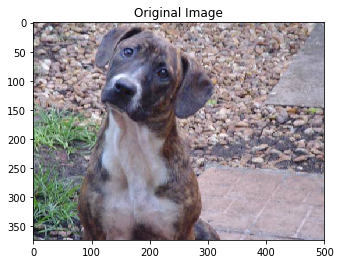

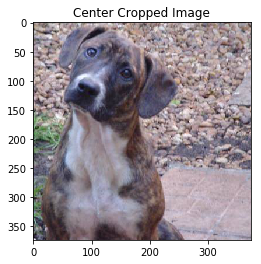

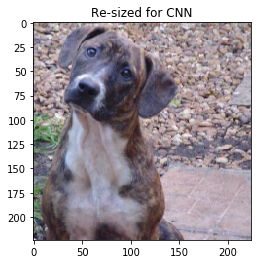

In [9]:
#%%
img = imgio.imread(os.path.join(IMG_DIR,'dogs',dog_imgs[13]))
fig,ax = plt.subplots();plt.imshow(img);ax.set_title('Original Image');plt.show()


img2 = center_crop_img(img)
fig,ax=plt.subplots();plt.imshow(img2);ax.set_title('Center Cropped Image');plt.show()


img3 = transform.resize(img2,EMBED_MODEL_SHAPE)
fig,ax = plt.subplots();plt.imshow(img3);ax.set_title('Re-sized for CNN');plt.show()

In [10]:
# generate array containing VGG16 sized images
def create_image(img_file):
    img = imgio.imread(img_file)
    img = center_crop_img(img)
    img = transform.resize(img,EMBED_MODEL_SHAPE)
    return img
    
cats = [create_image(os.path.join(IMG_DIR,'cats',f)) for f in cat_imgs]
dogs = [create_image(os.path.join(IMG_DIR,'dogs',f)) for f in dog_imgs]

images = np.vstack([cats,dogs])
images.shape

(2500, 224, 224, 3)

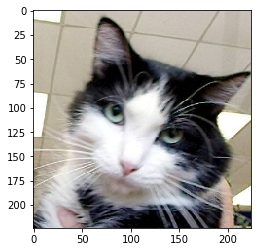

In [11]:
plt.imshow(images[1000]);plt.show()

In [12]:
#test for partial row
if (images.shape[0] % SPRITE_COLUMNS) != 0:
    number_images_to_fill = SPRITE_COLUMNS - \
            (images.shape[0] % SPRITE_COLUMNS)
    images_to_sprite = np.vstack([images,
              np.zeros([number_images_to_fill,images.shape[1],
                        images.shape[2],3])])
else:
    images_to_sprite = images
    
images_to_sprite = np.array([transform.resize(images[i],(SPRITE_IMG_SIZE,SPRITE_IMG_SIZE)) \
                             for i in range(images.shape[0])])

images_to_sprite.shape

(2500, 64, 64, 3)

In [13]:
rows = np.ceil(images_to_sprite.shape[0] / \
               float(SPRITE_COLUMNS)).astype('int')

sprite_image = np.vstack([
        np.hstack(images_to_sprite[r*SPRITE_COLUMNS:(r+1)*SPRITE_COLUMNS]) 
         for r in range(rows)])

sprite_image.shape

(3200, 3200, 3)

In [14]:
%time
plt.imsave(os.path.join(LOG_DIR,'cat_dog_sprite.png'),sprite_image)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 17.2 µs


In [15]:
### Generate digit label metadata
class_id = [0] * IMGS_TO_SELECT + [1] * IMGS_TO_SELECT
class_label = ['cat'] * IMGS_TO_SELECT + ['dog'] * IMGS_TO_SELECT

with open(os.path.join(LOG_DIR,'cat_dog_labels.tsv'),'w') as f:
    f.write('Class\tName\n')
    for i in range(len(class_id)):
        f.write('{}\t{}\n'.format(class_id[i],class_label[i]))

## Generate embeddings for selected images

In [16]:

embeddings = embed_model.predict(images,batch_size=8,verbose=1)

2500/2500 [==============================] - 293s   


In [17]:
embeddings.shape

(2500, 2048)

In [18]:
# prepare for saving to Tensorboard
embeddings = tf.Variable(embeddings, name='embeddings')

## Setup for use of Tensorboard

with tf.Session() as sess:
    saver = tf.train.Saver([embeddings])

    sess.run(embeddings.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'embeddings.ckpt'))
    
    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = embeddings.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = 'cat_dog_labels.tsv'
    # Comment out if you don't want sprites
    embedding.sprite\
        .image_path = 'cat_dog_sprite.png'
    embedding.sprite\
        .single_image_dim.extend([SPRITE_IMG_SIZE,SPRITE_IMG_SIZE])
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)




config.embeddings._values

[tensor_name: "embeddings:0"
 metadata_path: "cat_dog_labels.tsv"
 sprite {
   image_path: "cat_dog_sprite.png"
   single_image_dim: 64
   single_image_dim: 64
 }]